In [1]:
import torch
import random
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# ËÆæÁΩÆÈöèÊú∫ÁßçÂ≠êÁ°Æ‰øùÂèØÈáçÁé∞ÊÄß
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Ê£ÄÊü•CUDAÂèØÁî®ÊÄßÂπ∂ËÆæÁΩÆËÆæÂ§á
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"‰ΩøÁî®ËÆæÂ§á: {device}")
if torch.cuda.is_available():
    print(f"GPUÂêçÁß∞: {torch.cuda.get_device_name(0)}")
    print(f"GPUÂÜÖÂ≠ò: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# ËÆæÁΩÆÈªòËÆ§Êï∞ÊçÆÁ±ªÂûã
torch.set_default_dtype(torch.float32)

# ËÆæÁΩÆmatplotlibÂ≠ó‰Ωì‰∏∫Arial
plt.rcParams['font.family'] = 'Arial'

‰ΩøÁî®ËÆæÂ§á: cuda:0
GPUÂêçÁß∞: NVIDIA GeForce RTX 4070
GPUÂÜÖÂ≠ò: 12.0 GB


In [2]:
# ËØªÂèñÊï∞ÊçÆ
print("\n1. ËØªÂèñÊï∞ÊçÆ...")
data = pd.read_csv("../data/water_CNN_with_AlphaEarth_all_merged.csv")
print(f"Êï∞ÊçÆÂΩ¢Áä∂: {data.shape}")
print(f"Êï∞ÊçÆÂàó: {list(data.columns)}")

# Ê£ÄÊü•Ê†áÁ≠æÂàÜÂ∏É
landcover_counts = data['landcover'].value_counts()
print(f"\nÂéüÂßãÊ†áÁ≠æÂàÜÂ∏É:")
for label, count in landcover_counts.items():
    percentage = (count / len(data)) * 100
    print(f"  Á±ªÂà´ {label}: {count} ‰∏™Ê†∑Êú¨ ({percentage:.1f}%)")

# Â∞ÜÊ†áÁ≠æÈáçÊñ∞Êò†Â∞ÑÔºö0->0 (ÈùûÊ∞¥‰Ωì), 11->1 (Ê∞¥‰Ωì)
print("\nÈáçÊñ∞Êò†Â∞ÑÊ†áÁ≠æ: 0->0 (ÈùûÊ∞¥‰Ωì), 11->1 (Ê∞¥‰Ωì)")
data['landcover_binary'] = data['landcover'].map({0: 0, 11: 1})

# Ê£ÄÊü•ÈáçÊñ∞Êò†Â∞ÑÂêéÁöÑÊ†áÁ≠æÂàÜÂ∏É
binary_counts = data['landcover_binary'].value_counts()
print(f"\nÈáçÊñ∞Êò†Â∞ÑÂêéÊ†áÁ≠æÂàÜÂ∏É:")
for label, count in binary_counts.items():
    label_name = "ÈùûÊ∞¥‰Ωì" if label == 0 else "Ê∞¥‰Ωì"
    percentage = (count / len(data)) * 100
    print(f"  Á±ªÂà´ {label} ({label_name}): {count} ‰∏™Ê†∑Êú¨ ({percentage:.1f}%)")

# Êï∞ÊçÆÂàíÂàÜÔºö70%ËÆ≠ÁªÉÔºå30%È™åËØÅ
print("\n2. Êï∞ÊçÆÂàíÂàÜ...")
train_data = data[data['random'] <= 0.7]
val_data = data[data['random'] > 0.7]
print(f"ËÆ≠ÁªÉÈõÜÂ§ßÂ∞è: {len(train_data)}")
print(f"È™åËØÅÈõÜÂ§ßÂ∞è: {len(val_data)}")

# ÁâπÂæÅÂàóÔºöÂåÖÂê´AlphaEarthÂíåSentinel-2Ê≥¢ÊÆµ
feature_columns = ['A31', 'A36', 'A46', 'A47', 'A63', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
print(f"\n‰ΩøÁî®ÁâπÂæÅ: {feature_columns}")
print(f"ÁâπÂæÅÊï∞Èáè: {len(feature_columns)}")

# Â§ÑÁêÜËÆ≠ÁªÉÊï∞ÊçÆ
print("\n3. Â§ÑÁêÜËÆ≠ÁªÉÊï∞ÊçÆ...")
train_features_list = []
for col in feature_columns:
    col_data = np.array(train_data[col].apply(ast.literal_eval).values.tolist())
    train_features_list.append(col_data)

# Â†ÜÂè†ÁâπÂæÅ (Ê†∑Êú¨Êï∞, ÁâπÂæÅÊï∞, 3, 3) - Ê≥®ÊÑèËøôÈáåÊîπ‰∏∫3x3
train_features = np.stack(train_features_list, axis=1)
print(f"ËÆ≠ÁªÉÁâπÂæÅÂΩ¢Áä∂: {train_features.shape}")

# Êï∞ÊçÆÊòØ5x5Á™óÂè£Ôºå‰øùÊåÅÂéüÂßãÂ∞∫ÂØ∏
print(f"‰ΩøÁî®5x5Á™óÂè£ÔºåËÆ≠ÁªÉÁâπÂæÅÂΩ¢Áä∂: {train_features.shape}")

train_features = torch.tensor(train_features, dtype=torch.float32)
train_labels = torch.tensor(train_data['landcover_binary'].values, dtype=torch.long)

# Â§ÑÁêÜÈ™åËØÅÊï∞ÊçÆ
print("\n4. Â§ÑÁêÜÈ™åËØÅÊï∞ÊçÆ...")
val_features_list = []
for col in feature_columns:
    col_data = np.array(val_data[col].apply(ast.literal_eval).values.tolist())
    val_features_list.append(col_data)

val_features = np.stack(val_features_list, axis=1)
print(f"È™åËØÅÁâπÂæÅÂΩ¢Áä∂: {val_features.shape}")

# È™åËØÅÊï∞ÊçÆ‰πüÊòØ5x5Á™óÂè£
print(f"È™åËØÅÁâπÂæÅÂΩ¢Áä∂: {val_features.shape}")

val_features = torch.tensor(val_features, dtype=torch.float32)
val_labels = torch.tensor(val_data['landcover_binary'].values, dtype=torch.long)


1. ËØªÂèñÊï∞ÊçÆ...
Êï∞ÊçÆÂΩ¢Áä∂: (9899, 17)
Êï∞ÊçÆÂàó: ['A31', 'A36', 'A46', 'A47', 'A63', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'landcover', 'random']

ÂéüÂßãÊ†áÁ≠æÂàÜÂ∏É:
  Á±ªÂà´ 0: 7484 ‰∏™Ê†∑Êú¨ (75.6%)
  Á±ªÂà´ 11: 2415 ‰∏™Ê†∑Êú¨ (24.4%)

ÈáçÊñ∞Êò†Â∞ÑÊ†áÁ≠æ: 0->0 (ÈùûÊ∞¥‰Ωì), 11->1 (Ê∞¥‰Ωì)

ÈáçÊñ∞Êò†Â∞ÑÂêéÊ†áÁ≠æÂàÜÂ∏É:
  Á±ªÂà´ 0 (ÈùûÊ∞¥‰Ωì): 7484 ‰∏™Ê†∑Êú¨ (75.6%)
  Á±ªÂà´ 1 (Ê∞¥‰Ωì): 2415 ‰∏™Ê†∑Êú¨ (24.4%)

2. Êï∞ÊçÆÂàíÂàÜ...
ËÆ≠ÁªÉÈõÜÂ§ßÂ∞è: 6954
È™åËØÅÈõÜÂ§ßÂ∞è: 2945

‰ΩøÁî®ÁâπÂæÅ: ['A31', 'A36', 'A46', 'A47', 'A63', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
ÁâπÂæÅÊï∞Èáè: 15

3. Â§ÑÁêÜËÆ≠ÁªÉÊï∞ÊçÆ...
ËÆ≠ÁªÉÁâπÂæÅÂΩ¢Áä∂: (6954, 15, 5, 5)
‰ΩøÁî®5x5Á™óÂè£ÔºåËÆ≠ÁªÉÁâπÂæÅÂΩ¢Áä∂: (6954, 15, 5, 5)

4. Â§ÑÁêÜÈ™åËØÅÊï∞ÊçÆ...
È™åËØÅÁâπÂæÅÂΩ¢Áä∂: (2945, 15, 5, 5)
È™åËØÅÁâπÂæÅÂΩ¢Áä∂: (2945, 15, 5, 5)


In [3]:
# ÂàõÂª∫Êï∞ÊçÆÂä†ËΩΩÂô®
print("\n5. ÂàõÂª∫Êï∞ÊçÆÂä†ËΩΩÂô®...")
train_dataset = TensorDataset(train_features, train_labels)
val_dataset = TensorDataset(val_features, val_labels)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"ÊâπÊ¨°Â§ßÂ∞è: {batch_size}")
print(f"ËÆ≠ÁªÉÊâπÊ¨°Êï∞: {len(train_loader)}")
print(f"È™åËØÅÊâπÊ¨°Êï∞: {len(val_loader)}")

# ÂÆö‰πâCNNÊ®°Âûã - ÈÄÇÈÖç5x5ËæìÂÖ•Âíå15‰∏™ÁâπÂæÅÈÄöÈÅìÔºåÂèÇËÄÉÂéüÂßãgeeCNNÊû∂ÊûÑ
print("\n6. ÂÆö‰πâCNNÊ®°Âûã...")
class WaterCNN(nn.Module):
    def __init__(self, num_features=15, num_classes=2):
        super(WaterCNN, self).__init__()

        # ÂèÇËÄÉÂéüÂßãgeeCNNÊû∂ÊûÑÔºåÈÄÇÈÖç5x5Á™óÂè£
        self.conv1 = nn.Conv2d(in_channels=num_features, out_channels=16, kernel_size=(3, 3), padding=0)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0)
        self.conv3 = nn.Conv2d(in_channels=32 + num_features, out_channels=64, kernel_size=(1, 1))  # ËøûÊé•‰∏≠ÂøÉ1x1
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(1, 1))
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=num_classes, kernel_size=(1, 1))

    def forward(self, x):
        # x shape: (batch, 15, 5, 5)
        x1 = F.relu(self.conv1(x))  # (batch, 16, 3, 3) - 5x5 -> 3x3
        x2 = F.relu(self.conv2(x1))  # (batch, 32, 1, 1) - 3x3 -> 1x1

        # ÂèñÂéüÂßãËæìÂÖ•ÁöÑ‰∏≠ÂøÉ1x1Âå∫Âüü
        center_1x1 = x[:, :, 2:3, 2:3]  # (batch, 15, 1, 1) - ‰ªé5x5‰∏≠Âèñ‰∏≠ÂøÉ

        # ËøûÊé•ÁâπÂæÅ
        x3_input = torch.cat((x2, center_1x1), dim=1)  # (batch, 32+15=47, 1, 1)
        x3 = F.relu(self.conv3(x3_input))  # (batch, 64, 1, 1)
        x4 = F.relu(self.conv4(x3))  # (batch, 128, 1, 1)
        x5 = self.conv5(x4)  # (batch, 2, 1, 1)

        # Â±ïÂπ≥‰∏∫ÂàÜÁ±ªËæìÂá∫
        return x5.view(x5.size(0), -1)  # (batch, 2)

# ÂàõÂª∫Ê®°ÂûãÂπ∂ÁßªÂà∞GPU
model = WaterCNN(num_features=len(feature_columns), num_classes=2)
print(f"Ê®°ÂûãÂèÇÊï∞Êï∞Èáè: {sum(p.numel() for p in model.parameters())}")

# Á°Æ‰øùÊ®°ÂûãÂÆåÂÖ®ÁßªÂä®Âà∞ËÆæÂ§á
model = model.to(device)
print(f"Ê®°ÂûãÂ∑≤ÁßªÂä®Âà∞ËÆæÂ§á: {device}")

# Ê£ÄÊü•Ê®°ÂûãÂèÇÊï∞ËÆæÂ§á
for name, param in model.named_parameters():
    if param.device != device:
        print(f"Ë≠¶Âëä: ÂèÇÊï∞ {name} Âú®ËÆæÂ§á {param.device}ÔºåÂ∫îËØ•Âú® {device}")

# ÂÆö‰πâÊçüÂ§±ÂáΩÊï∞Âíå‰ºòÂåñÂô®
criterion = nn.CrossEntropyLoss()
##optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

print(f"ÊçüÂ§±ÂáΩÊï∞: {criterion}")
print(f"‰ºòÂåñÂô®: {optimizer}")


5. ÂàõÂª∫Êï∞ÊçÆÂä†ËΩΩÂô®...
ÊâπÊ¨°Â§ßÂ∞è: 8
ËÆ≠ÁªÉÊâπÊ¨°Êï∞: 870
È™åËØÅÊâπÊ¨°Êï∞: 369

6. ÂÆö‰πâCNNÊ®°Âûã...
Ê®°ÂûãÂèÇÊï∞Êï∞Èáè: 18466
Ê®°ÂûãÂ∑≤ÁßªÂä®Âà∞ËÆæÂ§á: cuda:0
ÊçüÂ§±ÂáΩÊï∞: CrossEntropyLoss()
‰ºòÂåñÂô®: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [4]:
# ËÆ≠ÁªÉÊ®°Âûã
print("\n7. ÂºÄÂßãËÆ≠ÁªÉ...")
num_epochs = 200
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_acc = 0.0
best_model_state = None

for epoch in range(num_epochs):
    # ËÆ≠ÁªÉÈò∂ÊÆµ
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        train_total += target.size(0)
        train_correct += (predicted == target).sum().item()
    
    # È™åËØÅÈò∂ÊÆµ
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            val_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            val_total += target.size(0)
            val_correct += (predicted == target).sum().item()
    
    # ËÆ°ÁÆóÂπ≥ÂùáÊçüÂ§±ÂíåÂáÜÁ°ÆÁéá
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_acc = 100 * train_correct / train_total
    val_acc = 100 * val_correct / val_total
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    # ‰øùÂ≠òÊúÄ‰Ω≥Ê®°Âûã
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
    
    # Êõ¥Êñ∞Â≠¶‰π†Áéá
    scheduler.step()
    
    # ÊâìÂç∞ËøõÂ∫¶
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'  Learning Rate: {scheduler.get_last_lr()[0]:.6f}')

print(f"\nËÆ≠ÁªÉÂÆåÊàêÔºÅÊúÄ‰Ω≥È™åËØÅÂáÜÁ°ÆÁéá: {best_val_acc:.2f}%")


7. ÂºÄÂßãËÆ≠ÁªÉ...
Epoch [5/200]
  Train Loss: 0.4733, Train Acc: 75.83%
  Val Loss: 0.4728, Val Acc: 75.08%
  Learning Rate: 0.001000
Epoch [10/200]
  Train Loss: 0.2184, Train Acc: 95.59%
  Val Loss: 0.2168, Val Acc: 95.31%
  Learning Rate: 0.000500
Epoch [15/200]
  Train Loss: 0.1613, Train Acc: 96.16%
  Val Loss: 0.1737, Val Acc: 95.55%
  Learning Rate: 0.000500
Epoch [20/200]
  Train Loss: 0.1411, Train Acc: 96.20%
  Val Loss: 0.1553, Val Acc: 95.72%
  Learning Rate: 0.000250
Epoch [25/200]
  Train Loss: 0.1346, Train Acc: 96.25%
  Val Loss: 0.1500, Val Acc: 95.76%
  Learning Rate: 0.000250
Epoch [30/200]
  Train Loss: 0.1304, Train Acc: 96.25%
  Val Loss: 0.1454, Val Acc: 95.89%
  Learning Rate: 0.000125
Epoch [35/200]
  Train Loss: 0.1294, Train Acc: 96.25%
  Val Loss: 0.1439, Val Acc: 95.89%
  Learning Rate: 0.000125
Epoch [40/200]
  Train Loss: 0.1269, Train Acc: 96.26%
  Val Loss: 0.1422, Val Acc: 95.93%
  Learning Rate: 0.000063
Epoch [45/200]
  Train Loss: 0.1261, Train Ac


8. ÊúÄÁªàËØÑ‰º∞...
ÊúÄÁªàÈ™åËØÅÂáÜÁ°ÆÁéá: 0.9596

ÂàÜÁ±ªÊä•Âëä:
              precision    recall  f1-score   support

         ÈùûÊ∞¥‰Ωì       0.96      0.98      0.97      2211
          Ê∞¥‰Ωì       0.95      0.89      0.92       734

    accuracy                           0.96      2945
   macro avg       0.96      0.94      0.94      2945
weighted avg       0.96      0.96      0.96      2945


Ê®°ÂûãÂ∑≤‰øùÂ≠òÂà∞: model/water_cnn_alpha_model.pth

9. ÁªòÂà∂ËÆ≠ÁªÉÊõ≤Á∫ø...


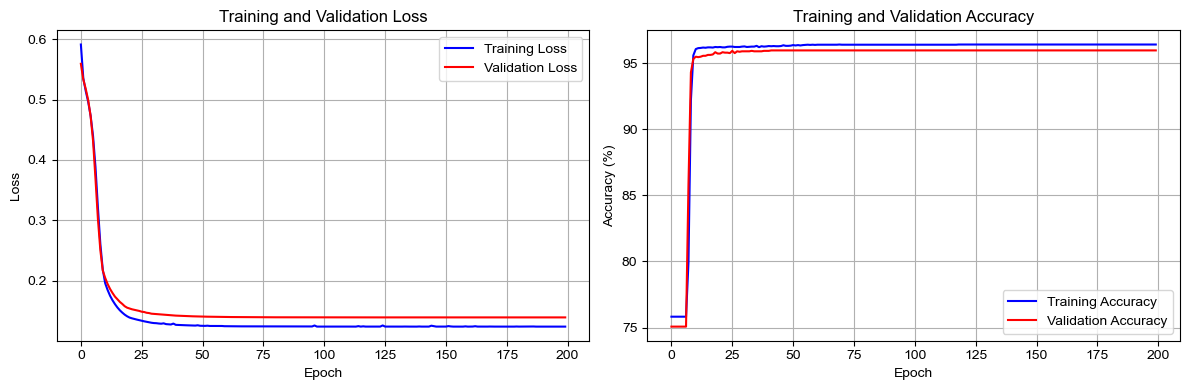


10. ÁªòÂà∂Ê∑∑Ê∑ÜÁü©Èòµ...


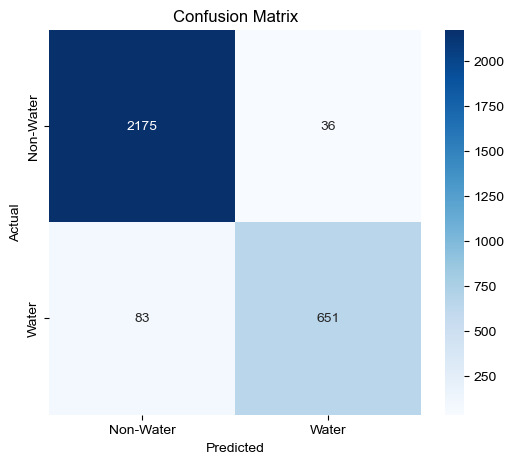


üéâ CNNÊ®°ÂûãËÆ≠ÁªÉÂÆåÊàêÔºÅ
ÊúÄÁªàÈ™åËØÅÂáÜÁ°ÆÁéá: 0.9596
Ê®°ÂûãÊñá‰ª∂: model/water_cnn_alpha_model.pth
ËÆ≠ÁªÉÊõ≤Á∫ø: model/training_curves.png
Ê∑∑Ê∑ÜÁü©Èòµ: model/confusion_matrix.png


In [5]:
# Âä†ËΩΩÊúÄ‰Ω≥Ê®°ÂûãËøõË°åÊúÄÁªàËØÑ‰º∞
model.load_state_dict(best_model_state)

# ÊúÄÁªàËØÑ‰º∞
print("\n8. ÊúÄÁªàËØÑ‰º∞...")
model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

# ËÆ°ÁÆóËØÑ‰º∞ÊåáÊ†á
final_accuracy = accuracy_score(all_targets, all_predictions)
print(f"ÊúÄÁªàÈ™åËØÅÂáÜÁ°ÆÁéá: {final_accuracy:.4f}")

print("\nÂàÜÁ±ªÊä•Âëä:")
print(classification_report(all_targets, all_predictions, 
                          target_names=['ÈùûÊ∞¥‰Ωì', 'Ê∞¥‰Ωì']))

# ‰øùÂ≠òÊ®°Âûã
model_path = "model/water_cnn_alpha_model.pth"
import os
os.makedirs("model", exist_ok=True)
torch.save(best_model_state, model_path)
print(f"\nÊ®°ÂûãÂ∑≤‰øùÂ≠òÂà∞: {model_path}")

# ÁªòÂà∂ËÆ≠ÁªÉÊõ≤Á∫ø
print("\n9. ÁªòÂà∂ËÆ≠ÁªÉÊõ≤Á∫ø...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# ÊçüÂ§±Êõ≤Á∫ø
ax1.plot(train_losses, label='Training Loss', color='blue')
ax1.plot(val_losses, label='Validation Loss', color='red')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# ÂáÜÁ°ÆÁéáÊõ≤Á∫ø
ax2.plot(train_accuracies, label='Training Accuracy', color='blue')
ax2.plot(val_accuracies, label='Validation Accuracy', color='red')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('model/training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# ÁªòÂà∂Ê∑∑Ê∑ÜÁü©Èòµ
print("\n10. ÁªòÂà∂Ê∑∑Ê∑ÜÁü©Èòµ...")
cm = confusion_matrix(all_targets, all_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Water', 'Water'],
            yticklabels=['Non-Water', 'Water'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('model/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nüéâ CNNÊ®°ÂûãËÆ≠ÁªÉÂÆåÊàêÔºÅ")
print(f"ÊúÄÁªàÈ™åËØÅÂáÜÁ°ÆÁéá: {final_accuracy:.4f}")
print(f"Ê®°ÂûãÊñá‰ª∂: {model_path}")
print("ËÆ≠ÁªÉÊõ≤Á∫ø: model/training_curves.png")
print("Ê∑∑Ê∑ÜÁü©Èòµ: model/confusion_matrix.png")

In [6]:
path_trained_model = 'model/water_cnn_alpha_model.pth'
model = WaterCNN()
model.load_state_dict(torch.load(path_trained_model))
model.eval()

weights_and_biases = {}

for layer_name, params in model.named_parameters():
    weights_and_biases[layer_name] = params.detach().numpy().tolist()

In [7]:
weights_and_biases.keys()

dict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias', 'conv4.weight', 'conv4.bias', 'conv5.weight', 'conv5.bias'])

In [ ]:
print(weights_and_biases['conv5.weight'])

[[[[0.029604211449623108]], [[0.055915214121341705]], [[0.07540883868932724]], [[-0.050294097512960434]], [[-0.11346714198589325]], [[0.09506802260875702]], [[0.027703644707798958]], [[0.06720340996980667]], [[0.2155243456363678]], [[-0.15974555909633636]], [[0.02615516260266304]], [[0.1160387322306633]], [[0.06144069880247116]], [[-0.1481848657131195]], [[-0.06899847835302353]], [[-0.04332266375422478]], [[-0.1331150084733963]], [[-0.020399635657668114]], [[-0.08456649631261826]], [[0.03644039109349251]], [[0.08861946314573288]], [[0.1665755808353424]], [[0.047320954501628876]], [[-0.08703121542930603]], [[-0.015231185592710972]], [[0.14160360395908356]], [[0.04610791057348251]], [[0.05954702943563461]], [[-0.07641586661338806]], [[0.17005132138729095]], [[0.03732772916555405]], [[-0.06207260116934776]], [[0.08880298584699631]], [[0.05665929242968559]], [[0.06068494915962219]], [[0.017160475254058838]], [[-0.03437579423189163]], [[-0.03098398633301258]], [[-0.03157244995236397]], [[0.